# Imports

In [1]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
random_state = 42

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

# Data frame creation

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
data = fetch_ucirepo(id=350) 
  
# convert features and targets to a pandas DataFrame
df = pd.DataFrame(data.data.features, columns=data.data.feature_names)
df['DEFAULT'] = data.data.targets  # Add the target column to the DataFrame

# Rename columns
df.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
df.rename(columns=lambda x: x.upper(), inplace=True)

# Rename X0-Xn columns to more descriptive names
df.rename(columns={
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_1',
    'X7': 'PAY_2',
    'X8': 'PAY_3',
    'X9': 'PAY_4',
    'X10': 'PAY_5',
    'X11': 'PAY_6',
    'X12': 'BILL_AMT1',
    'X13': 'BILL_AMT2',
    'X14': 'BILL_AMT3',
    'X15': 'BILL_AMT4',
    'X16': 'BILL_AMT5',
    'X17': 'BILL_AMT6',
    'X18': 'PAY_AMT1',
    'X19': 'PAY_AMT2',
    'X20': 'PAY_AMT3',
    'X21': 'PAY_AMT4',
    'X22': 'PAY_AMT5',
    'X23': 'PAY_AMT6',
    'X24': 'DEFAULT'
}, inplace=True)


df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

# Data Cleaning
LIMIT BAL, SEX, and AGE attributes have correct values as defined
but MARRIAGE and EDUCATION both have unexpected categories.
MARRIAGE should range from 1 to 3 (but is 0 to 3) and EDUCATION should range from 1 to 4 (but is 0 to 6)
We should remove these categories so they do not affect the data

In [3]:
df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe()
print(f"Dataset size before:\t{df.shape[0]}")

# Remove rows of X3 with value 0, 5, or 6
df = df[~df['EDUCATION'].isin([0, 5, 6])]
df['EDUCATION'].describe()

# Remove rows of X4 with value 0
df = df[~df['MARRIAGE'].isin([0])]
df['MARRIAGE'].describe()

print(f"Dataset size after:\t{df.shape[0]}")

Dataset size before:	30000
Dataset size after:	29601


PAY_1 - PAY_6 should have values of -1, 1, 2, 3, up to 9 but instead have a minimum of -2 and a max of 8, so it looks like the data is one number off so we need to add 1 to each value

In [4]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

# Add 1 to all values in the PAY_X columns
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] += 1
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()



,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000
mean,0.985068,0.868687,0.836560,0.781697,0.736022,0.712442
std,1.124503,1.199642,1.199793,1.172220,1.136217,1.152206
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


Nothing wrong in BILL_AMNT or PAY_AMNT

In [5]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()


,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000,29601.000000
mean,5649.560319,5.894788e+03,5198.415898,4828.659268,4795.032735,5181.326374
std,16568.264941,2.308919e+04,17580.914806,15711.057992,15244.217154,17657.260739
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.250000e+02,390.000000,298.000000,259.000000,138.000000
50%,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4014.000000,4042.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


Handle categorical features EDUCATION, SEX, and MARRIAGE using one-hot encoding

In [6]:
# Feature engineering: Apply transformations to the entire dataset before splitting
df['MALE'] = df['SEX'].map({1: 0, 2: 1}).astype('category')
df['MARRIED'] = df['MARRIAGE'].map({1: 1, 2: 0, 3: 0}).astype('category')
df['GRAD_SCHOOL'] = (df['EDUCATION'] == 1).astype('category')
df['UNIVERSITY'] = (df['EDUCATION'] == 2).astype('category')
df['HIGH_SCHOOL'] = (df['EDUCATION'] == 3).astype('category')

# Drop the original columns after feature engineering
df.drop(columns=['SEX', 'MARRIAGE', 'EDUCATION'], inplace=True)

# Train-test split
X = df.drop(columns=['DEFAULT'])
y = df['DEFAULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25, stratify=y)
print(f"Training set size:\t{X_train.shape[0]}")
print(f"Testing set size:\t{X_test.shape[0]}")


Training set size:	22200
Testing set size:	7401


Normalize data

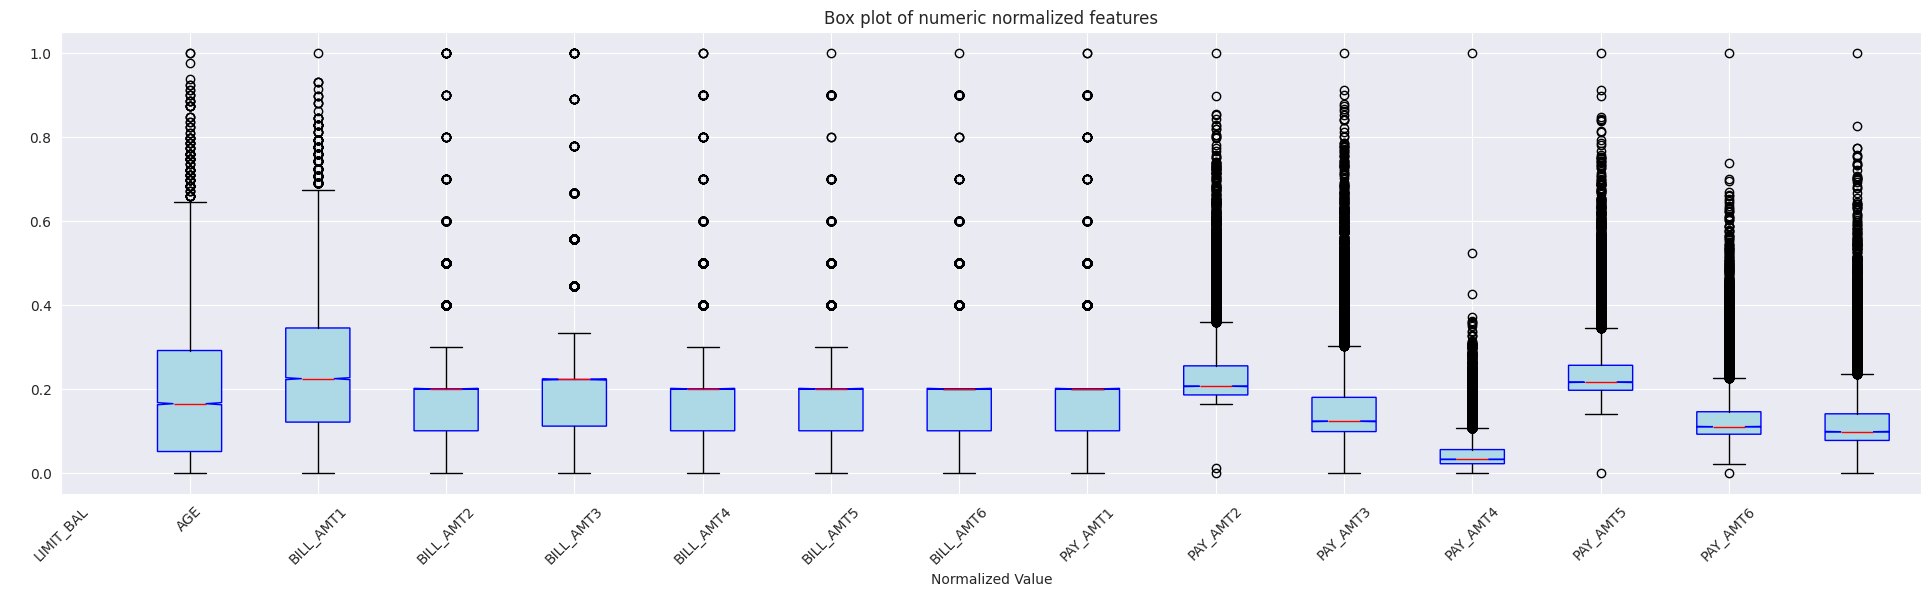

In [7]:
# Normalize the data to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale all columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Box plot of numeric normalized features
numeric_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X_train_normalized = pd.DataFrame(X_train_scaled[:, :len(numeric_features)], columns=numeric_features)
X_test_normalized = pd.DataFrame(X_test_scaled[:, :len(numeric_features)], columns=numeric_features)

plt.figure(figsize=(24, 6))
plt.boxplot(x=X_train_normalized, patch_artist=True, notch=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.xticks(rotation=45)
plt.xticks(ticks=range(len(numeric_features)), labels=numeric_features, rotation=45)
plt.title('Box plot of numeric normalized features')
plt.xlabel('Normalized Value')
plt.ylabel(' ')
plt.show()


# Dimensionality Reduction

PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.239141,-0.238335,-0.075859,-0.180456,0.151088,0.031342,0.074788,-0.059080,-0.019093,0.007574,-0.000861,0.007623
1,0.069307,0.103653,0.049981,-0.065913,-0.030421,-0.003695,0.004312,-0.000344,-0.004257,0.014812,-0.002453,0.000794
2,-0.171323,-0.070961,-0.097003,0.074861,0.093415,0.122990,-0.053755,0.019256,0.004645,0.002002,0.003119,-0.003009
3,-0.046790,0.472667,0.092224,-0.013764,0.100727,-0.064790,-0.061243,-0.028467,0.034889,-0.198683,0.165851,0.010851
4,0.145675,0.079444,0.100397,-0.034361,-0.070864,-0.039376,-0.103658,-0.089754,-0.083237,-0.088819,-0.000167,-0.004034


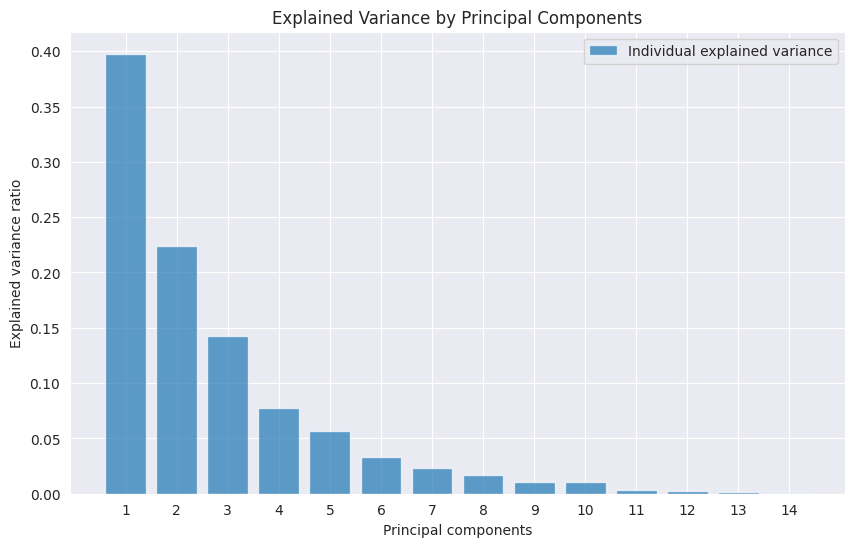

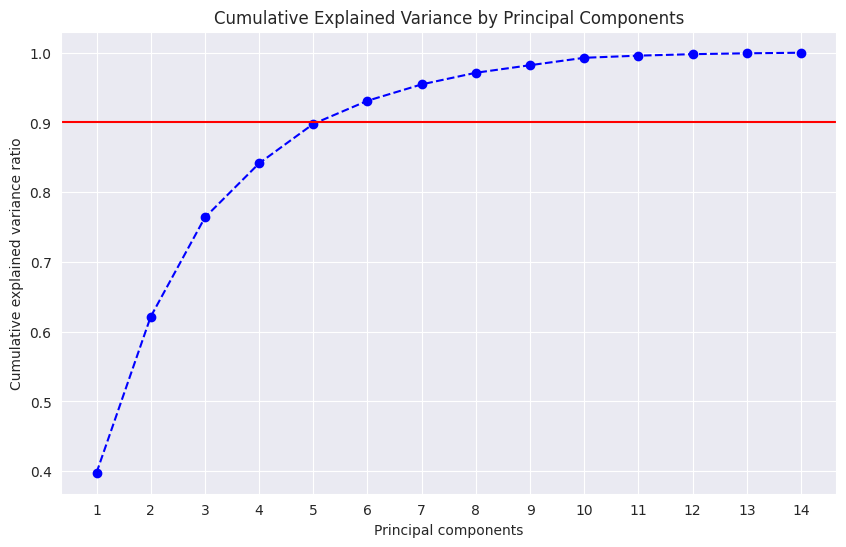

In [8]:
from sklearn.decomposition import PCA

principal_component = len(X_train_normalized.columns.values)
pca = PCA(n_components=principal_component)
pca.fit(X_train_normalized)
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, principal_component + 1), explained_variance, alpha=0.7, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, principal_component + 1))
plt.legend(loc='best')

# % explained by first 5 components
explained_variance_cumsum = np.cumsum(explained_variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, principal_component + 1), explained_variance_cumsum, marker='o', linestyle='--', color='blue')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('Principal components')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xticks(range(1, principal_component + 1))
plt.axhline(y=0.9, color='r', linestyle='-', label='90% threshold')


pca = PCA(n_components=12)
pca.fit(X_train_normalized)
X_train_pca = pca.transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(12)])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(12)])
X_train_pca.head()


K-Means sampling

In [9]:
from sklearn.cluster import KMeans
import numpy as np

# Separate the training data into default and non-default classes
X_train_default = X_train[y_train == 1]
X_train_non_default = X_train[y_train == 0]

# Set the number of clusters to match the smaller class size
n_clusters = len(X_train_default)

# Apply KMeans clustering to the larger class (non-default)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_train_non_default['cluster'] = kmeans.fit_predict(X_train_non_default)

# Select one representative sample from each cluster
X_train_non_default_sampled = X_train_non_default.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)

# Combine the sampled non-default data with the default data
X_train_kmeans = pd.concat([X_train_non_default_sampled.drop(columns=['cluster']), X_train_default])
y_train_kmeans = np.concatenate([np.zeros(len(X_train_non_default_sampled)), np.ones(len(X_train_default))])

# Shuffle the data
from sklearn.utils import shuffle
X_train_kmeans, y_train_kmeans = shuffle(X_train_kmeans, y_train_kmeans, random_state=42)

# Display the class proportions
class_counts = pd.Series(y_train_kmeans).value_counts()
class_count_df = pd.DataFrame({
    'Class': ['Non-defaulters', 'Defaulters'],
    'Number': class_counts.values,
    'Percentage': [f"{(count / class_counts.sum()) * 100:.2f}%" for count in class_counts.values]
})

print('Training set class proportion after K-Means Sampling')
class_count_df

Training set class proportion after K-Means Sampling


,Class,Number,Percentage
0,Non-defaulters,4954,50.00%
1,Defaulters,4954,50.00%


K Means SMOTE

In [10]:
from imblearn.over_sampling import KMeansSMOTE
import numpy as np
import pandas as pd

# Separate the minority (defaulters) and majority (non-defaulters) classes


oversample = KMeansSMOTE(cluster_balance_threshold=0.00001, random_state=25)
X_train_ksmote, y_train_ksmote = oversample.fit_resample(X_train, y_train)


class_counts = pd.Series(y_train_ksmote).value_counts()
class_count_df = pd.DataFrame({
    'Class': ['Non-defaulters', 'Defaulters'],
    'Number': class_counts.values,
    'Percentage': [f"{(count / class_counts.sum()) * 100:.2f}%" for count in class_counts.values]
})

# Display the class proportions
print('Training set class proportion after KMeansSMOTE')
print(class_count_df)

Training set class proportion after KMeansSMOTE
            Class  Number Percentage
0  Non-defaulters   17253     50.01%
1      Defaulters   17246     49.99%


# Key Statistics and Data Presentation

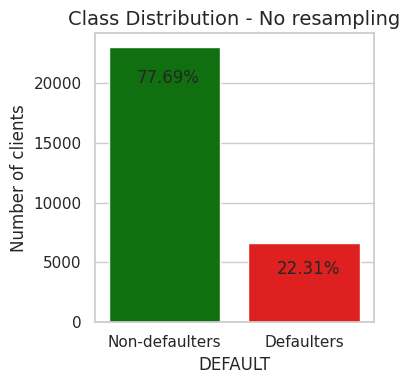

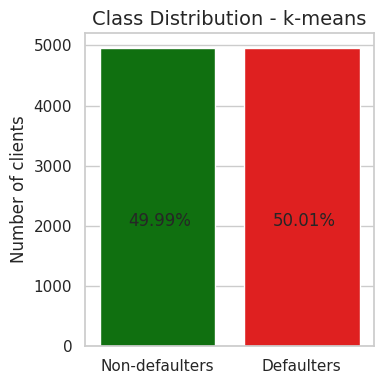

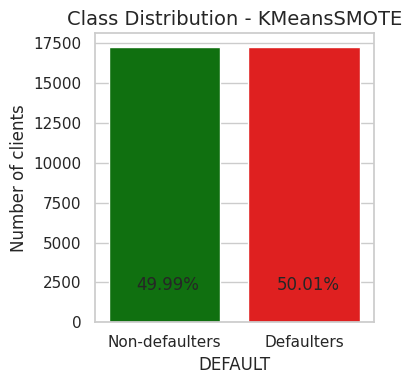

In [11]:
# Only 6605/22996 are defaulters which is the minority and will be less important to the model
df['DEFAULT'].value_counts()

plt.figure(figsize = (4,4))
graph_target = sns.countplot(x="DEFAULT", data=df, palette=['Green','Red'])
# Plot % of each class of the whole
plt.text(-0.2, 20000, f'{df["DEFAULT"].value_counts()[0]/df.shape[0]*100:.2f}%', fontsize=12)
plt.text(0.8, 4000, f'{df["DEFAULT"].value_counts()[1]/df.shape[0]*100:.2f}%', fontsize=12)
plt.title('Class Distribution - No resampling', fontsize=14)
plt.xticks([0,1],['Non-defaulters', 'Defaulters'])
plt.ylabel('Number of clients')
plt.tight_layout()
plt.show()


# Plot class distribution after k-means sampling
plt.figure(figsize=(4, 4))
sns.countplot(x=y_train_kmeans, palette=['Green', 'Red'])
plt.title('Class Distribution - k-means', fontsize=14)
plt.xticks([0, 1], ['Non-defaulters', 'Defaulters'])
plt.ylabel('Number of clients')
plt.text(-0.2, 2000, f'{class_counts[0]/class_counts.sum()*100:.2f}%', fontsize=12)
plt.text(0.8, 2000, f'{class_counts[1]/class_counts.sum()*100:.2f}%', fontsize=12)
plt.tight_layout()
plt.show()

# Plot class distribution after KMeansSMOTE
plt.figure(figsize=(4, 4))
sns.countplot(x=y_train_ksmote, palette=['Green', 'Red'])
plt.title('Class Distribution - KMeansSMOTE', fontsize=14)
plt.xticks([0, 1], ['Non-defaulters', 'Defaulters'])
plt.ylabel('Number of clients')
plt.text(-0.2, 2000, f'{class_counts[0]/class_counts.sum()*100:.2f}%', fontsize=12)
plt.text(0.8, 2000, f'{class_counts[1]/class_counts.sum()*100:.2f}%', fontsize=12)
plt.tight_layout()
plt.show()



Data visualizations


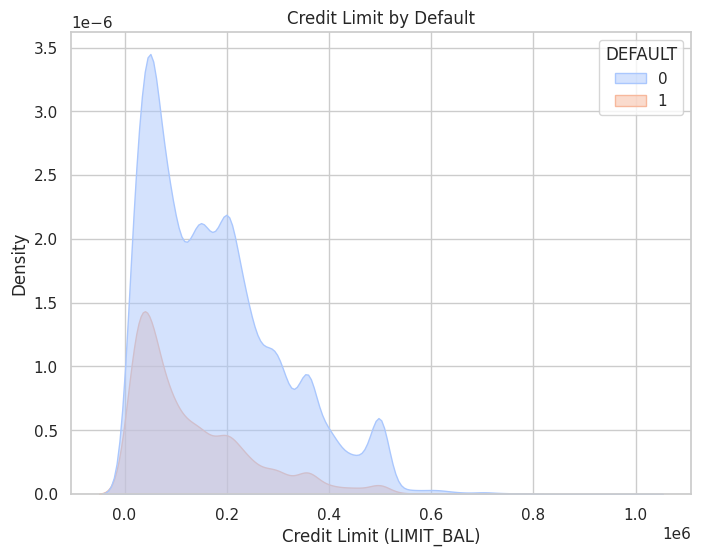

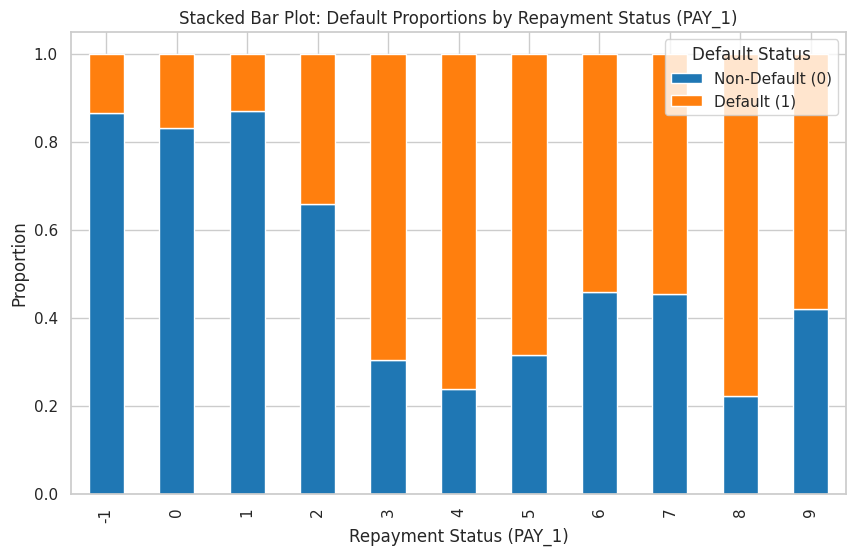

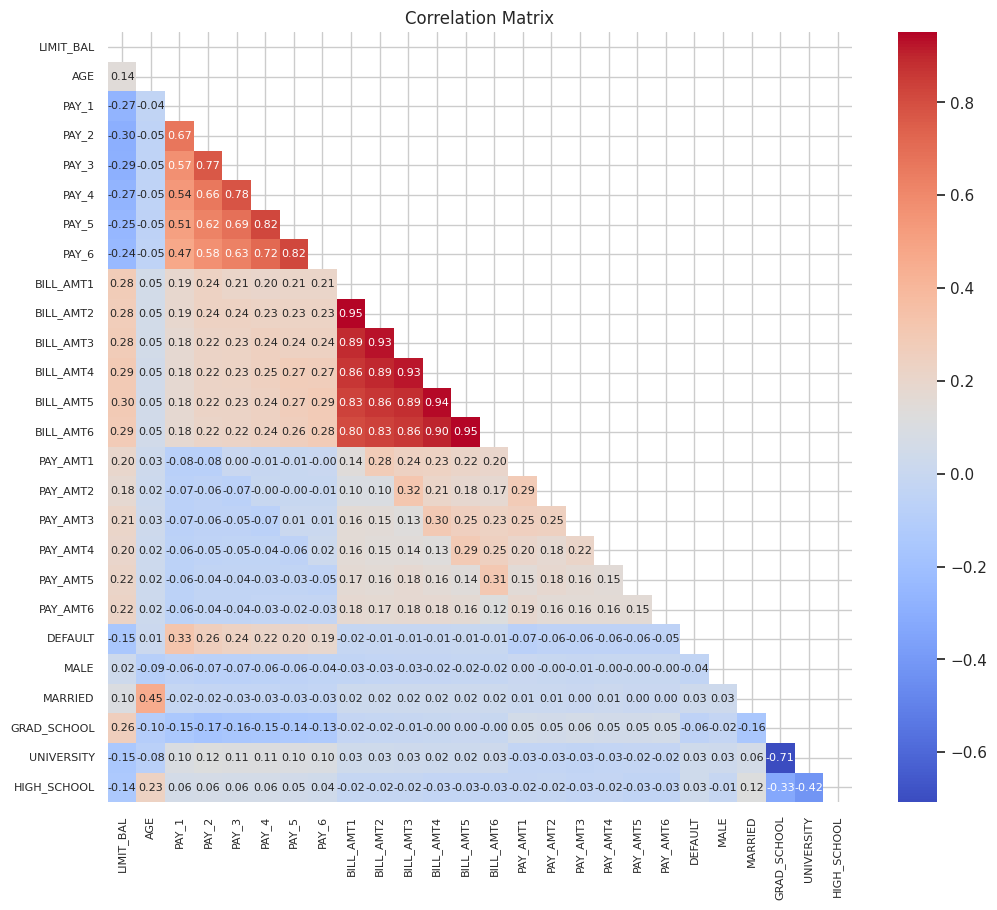

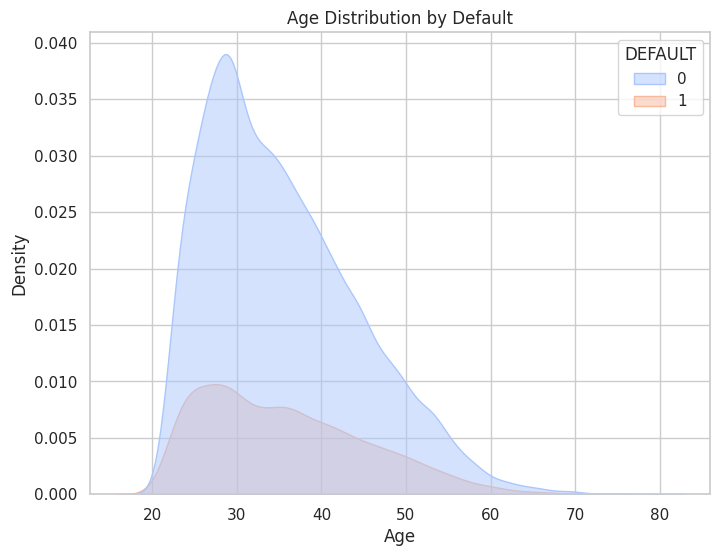

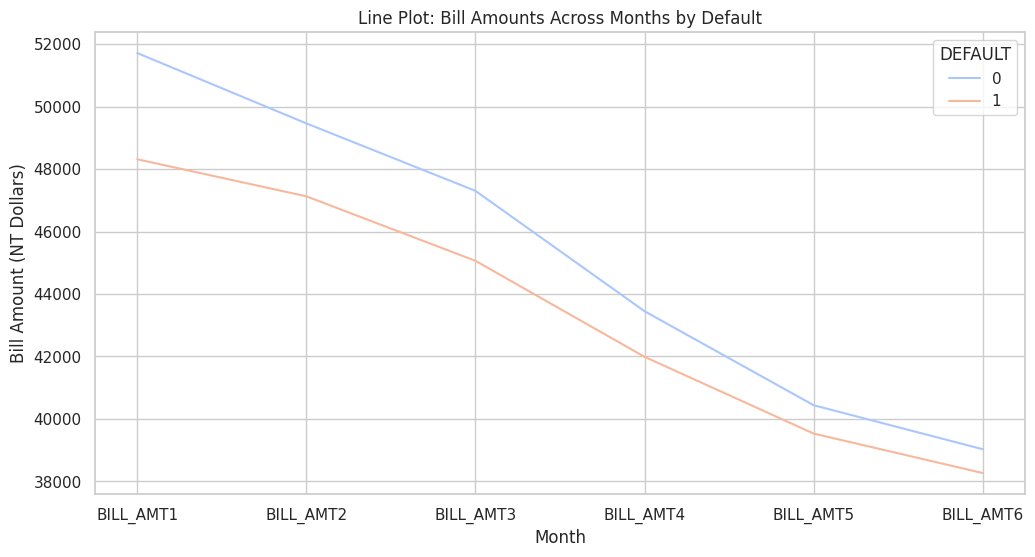

In [13]:
# Set a style for the plots
sns.set(style="whitegrid")

# 1. Density Plot: Credit Limit by Default
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='LIMIT_BAL', hue='DEFAULT', fill=True, palette='coolwarm', alpha=0.5)
plt.title('Credit Limit by Default')
plt.xlabel('Credit Limit (LIMIT_BAL)')
plt.ylabel('Density')
plt.show()

# 2. Box Plot: Payment History vs. Default
# Calculate proportions of default and non-default for each repayment status
pay_default = df.groupby('PAY_1')['DEFAULT'].value_counts(normalize=True).unstack()

# Plot a stacked bar chart
pay_default.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Stacked Bar Plot: Default Proportions by Repayment Status (PAY_1)')
plt.xlabel('Repayment Status (PAY_1)')
plt.ylabel('Proportion')
plt.legend(['Non-Default (0)', 'Default (1)'], title='Default Status')
plt.show()

# 3. Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# 4. Distribution Plot: Age
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='AGE', hue='DEFAULT', fill=True, palette='coolwarm', alpha=0.5)
plt.title('Age Distribution by Default')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

# 5. Box Plot: Bill Amounts
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
df_melted = df.melt(id_vars='DEFAULT', value_vars=bill_columns, var_name='Month', value_name='Bill Amount')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='Month', y='Bill Amount', hue='DEFAULT', palette='coolwarm', ci=None)
plt.title('Line Plot: Bill Amounts Across Months by Default')
plt.xlabel('Month')
plt.ylabel('Bill Amount (NT Dollars)')
plt.show()

## Model Evaluation


Training with Raw data
Class distribution with raw:
- Non-defaulters (0): 17246 (77.68%)
- Defaulters (1): 4954 (22.32%)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/camster/repos/Data Science/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/camster/repos/Data Science/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best parameters: {'C': 100.0}
Best validation score: 0.3038
Test Scores:
- Accuracy:	0.7907
- Recall:	0.1236
- Precision:	0.6667
- F1-score:	0.2085
- AUC:		0.4558


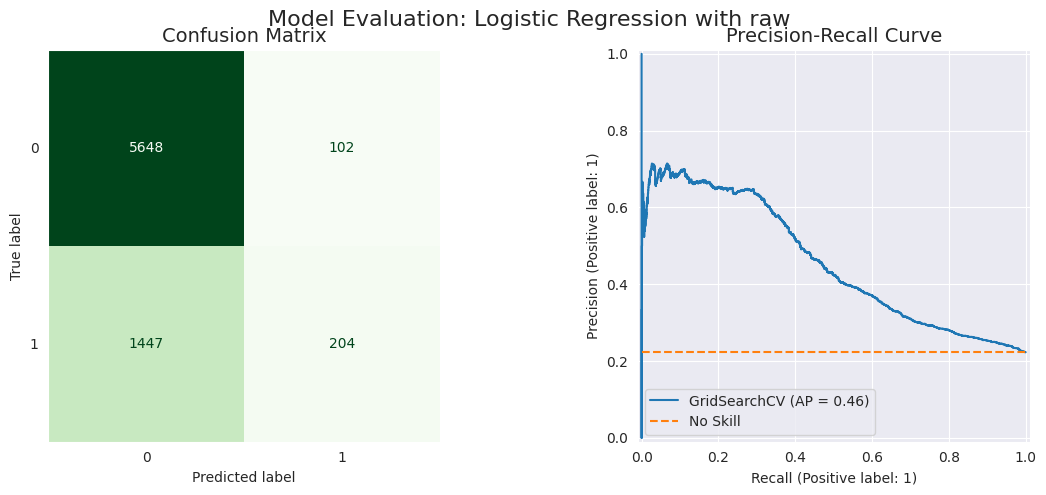


Training with PCA
Applying PCA transformation...
Variance explained by first 12 components: 0.8748
PCA transformed data shape: (22200, 12)
First few values of transformed data:
        PC1       PC2       PC3
0 -2.723864 -0.413448 -0.522213
1  1.523089 -0.121363 -1.385005
2 -1.980207  0.049959  0.012469
Class distribution with pca:
- Non-defaulters (0): 17246 (77.68%)
- Defaulters (1): 4954 (22.32%)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 1.0}
Best validation score: 0.2833
Test Scores:
- Accuracy:	0.7985
- Recall:	0.1781
- Precision:	0.6869
- F1-score:	0.2828
- AUC:		0.4762


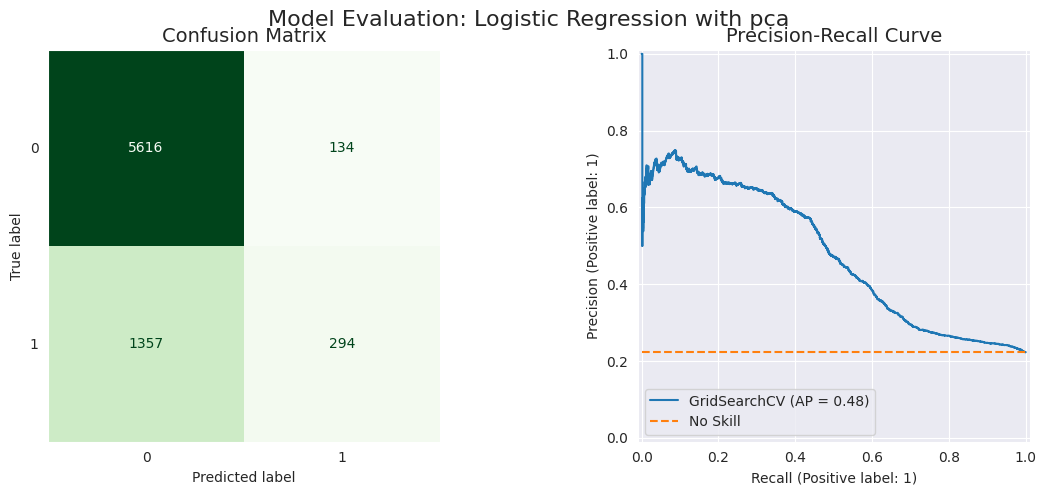


Training with PCA + K-Means sampling
Class distribution with kmeans:
- Non-defaulters (0): 4954 (50.00%)
- Defaulters (1): 4954 (50.00%)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 10.0}
Best validation score: 0.7674
Test Scores:
- Accuracy:	0.4810
- Recall:	0.8286
- Precision:	0.2777
- F1-score:	0.4160
- AUC:		0.4553


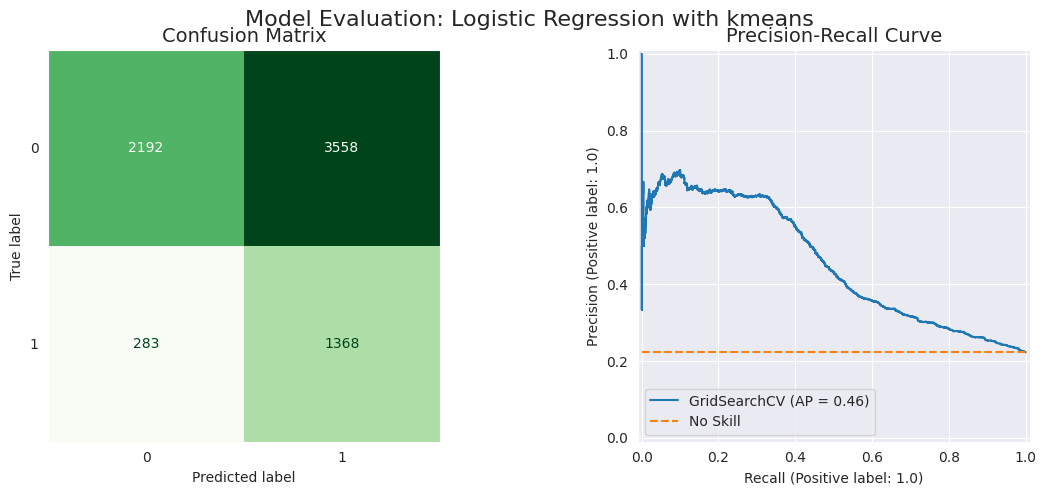


Training with PCA + KMeansSMOTE
Class distribution with kmeans_smote:
- Non-defaulters (0): 17246 (49.99%)
- Defaulters (1): 17252 (50.01%)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 1.0}
Best validation score: 0.8248
Test Scores:
- Accuracy:	0.7680
- Recall:	0.4506
- Precision:	0.4788
- F1-score:	0.4643
- AUC:		0.4564


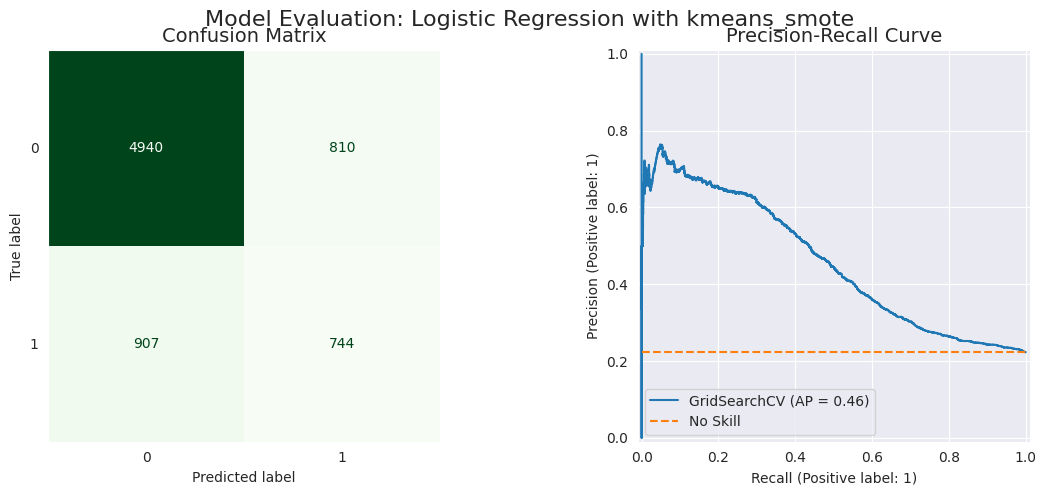

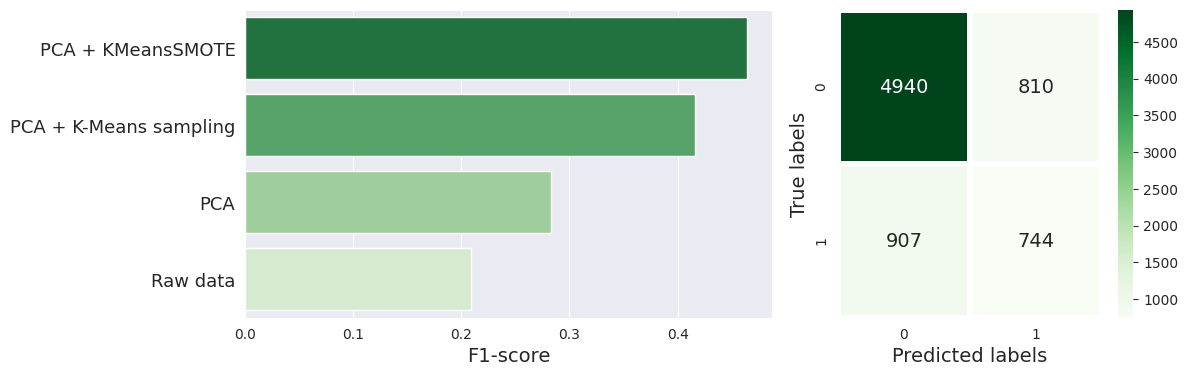

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.790704,0.123561,0.666667,0.208482,0.455848
PCA,0.798541,0.178074,0.686916,0.282828,0.476184
PCA + K-Means sampling,0.481016,0.828589,0.277710,0.415995,0.455282
PCA + KMeansSMOTE,0.768004,0.450636,0.478764,0.464275,0.456405


In [20]:
## Model Evaluation
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from imblearn.over_sampling import KMeansSMOTE
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

def plot_model_evaluation(model, X_test, y_test, model_name="Model"):
    """
    Create comprehensive visualizations for model evaluation.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Create figure with subplots - removed feature importance
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Model Evaluation: {model_name}", fontsize=16)
    
    # 1. Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, 
        cmap=plt.cm.Greens, 
        ax=axs[0],
        colorbar=False
    )
    axs[0].set_title("Confusion Matrix", fontsize=14)
    axs[0].grid(False)
    
    # 2. Precision-Recall Curve
    if y_pred_proba is not None:
        # Calculate no-skill line (proportion of positive class)
        no_skill = len(y_test[y_test == 1]) / len(y_test)
        
        PrecisionRecallDisplay.from_estimator(
            model, X_test, y_test, 
            ax=axs[1]
        )
        axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        axs[1].set_title("Precision-Recall Curve", fontsize=14)
        axs[1].legend(loc='lower left')
    else:
        axs[1].text(0.5, 0.5, "Probability predictions not available", 
                   ha='center', va='center', fontsize=12)
        axs[1].set_title("Precision-Recall Curve (Not Available)", fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def plot_summary(result, resampling_names, y_pred, y_test):
    """
    Plot summary of model performance across different resampling methods.
    """
    fig = plt.figure(constrained_layout=False, figsize=(14, 4))
    gs1 = fig.add_gridspec(nrows=1, ncols=6, left=0.1, right=0.90, wspace=0.5, hspace=0.5)
    ax1 = fig.add_subplot(gs1[0, 0:3])
    ax2 = fig.add_subplot(gs1[0, 3:5])
    
    plot_x = []
    plot_y = []
    
    for i in range(len(result)):
        plot_x.append(result[i])
        plot_y.append(resampling_names[i])

    temp_df = pd.DataFrame({'x': plot_x, 'y': plot_y}).sort_values(['x'], ascending=False)
    
    # plot barchart
    sns.barplot(data=temp_df, x='x', y='y', 
                palette='Greens_r',
                ax=ax1)
    ax1.set_xlabel("F1-score", fontsize="14")
    ax1.set_ylabel("")
    ax1.set_yticklabels(temp_df.y, fontsize=13)
    
    # confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, 
                cmap=plt.cm.Greens, 
                annot_kws={"size": 14},
                linecolor='w',
                linewidth=4, ax=ax2,
                fmt='d'
               )
    
    ax2.set_xlabel("Predicted labels", fontsize="14")
    ax2.set_ylabel("True labels", fontsize="14")
    
    plt.show()
    return plt

def handle_missing_values(X):
    """
    Handle missing values in the dataset.
    """
    if isinstance(X, pd.DataFrame):
        # For numeric columns, impute with mean
        imputer = SimpleImputer(strategy='mean')
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        return X_imputed
    else:
        # For numpy arrays
        imputer = SimpleImputer(strategy='mean')
        return imputer.fit_transform(X)

def pipeline(model, params, method='raw', n_components=12, random_state=42):
    """
    Run the complete modeling pipeline with specified preprocessing and sampling method.
    
    Parameters:
    -----------
    model : sklearn estimator
        The model to train
    params : dict
        Parameter grid for GridSearchCV
    method : str, default='raw'
        Preprocessing method: 'raw', 'pca', 'kmeans', 'kmeans_smote'
    n_components : int, default=12
        Number of PCA components to use
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    tuple
        (test_scores, y_pred, y_test)
    """
    # Handle missing values in both train and test sets
    X_train_clean = handle_missing_values(X_train)
    X_test_clean = handle_missing_values(X_test)
    
    # Normalize data for all methods (important for PCA)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_norm = pd.DataFrame(
        scaler.fit_transform(X_train_clean),
        columns=X_train_clean.columns
    )
    X_test_norm = pd.DataFrame(
        scaler.transform(X_test_clean),
        columns=X_test_clean.columns
    )
    
    # Apply the specified method
    if method == 'raw':
        # Raw data - no PCA, no sampling
        X_train_processed = X_train_clean
        X_test_processed = X_test_clean
        y_train_processed = y_train
        
    elif method == 'pca':
        # Apply PCA on normalized data
        print("Applying PCA transformation...")
        pca = PCA(n_components=n_components, random_state=random_state)
        pca.fit(X_train_norm)  # Fit on normalized training data
        
        # Print variance explained (for verification)
        explained_variance = pca.explained_variance_ratio_
        print(f"Variance explained by first {n_components} components: {sum(explained_variance):.4f}")
        
        # Transform both training and test data
        X_train_pca = pca.transform(X_train_norm)
        X_test_pca = pca.transform(X_test_norm)
        
        # Convert to DataFrame with proper column names
        X_train_processed = pd.DataFrame(X_train_pca, 
                                        columns=[f'PC{i}' for i in range(1, n_components+1)])
        X_test_processed = pd.DataFrame(X_test_pca, 
                                       columns=[f'PC{i}' for i in range(1, n_components+1)])
        
        # Verify the transformation (for debugging)
        print(f"PCA transformed data shape: {X_train_processed.shape}")
        print(f"First few values of transformed data:\n{X_train_processed.iloc[:3, :3]}")
        
        y_train_processed = y_train.reset_index(drop=True)
        
    elif method == 'kmeans':
            # Apply PCA first on normalized data
            pca = PCA(n_components=n_components, random_state=random_state)
            pca.fit(X_train_norm)
            
            X_train_pca = pca.transform(X_train_norm)
            X_test_pca = pca.transform(X_test_norm)
            
            # Convert to DataFrame and ensure indices match
            X_train_pca_df = pd.DataFrame(X_train_pca, 
                                        columns=[f'PC{i}' for i in range(1, n_components+1)])
            X_test_processed = pd.DataFrame(X_test_pca, 
                                        columns=[f'PC{i}' for i in range(1, n_components+1)])
            
            # Reset indices to ensure alignment
            X_train_pca_df = X_train_pca_df.reset_index(drop=True)
            y_train_reset = y_train.reset_index(drop=True)
            
            # Then apply K-Means sampling with aligned indices
            # Separate the training data into default and non-default classes
            X_train_default = X_train_pca_df[y_train_reset == 1]
            X_train_non_default = X_train_pca_df[y_train_reset == 0]
            
            # Set the number of clusters to match the smaller class size
            n_clusters = len(X_train_default)
            
            # Apply KMeans clustering to the larger class (non-default)
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
            X_train_non_default_copy = X_train_non_default.copy()
            X_train_non_default_copy['cluster'] = kmeans.fit_predict(X_train_non_default)
            
            # Select one representative sample from each cluster
            X_train_non_default_sampled = X_train_non_default_copy.groupby('cluster').apply(
                lambda x: x.sample(1, random_state=random_state)
            ).reset_index(drop=True).drop(columns=['cluster'])
            
            # Combine the sampled non-default data with the default data
            X_train_processed = pd.concat([X_train_non_default_sampled, X_train_default])
            y_train_processed = pd.Series(
                np.concatenate([
                    np.zeros(len(X_train_non_default_sampled)), 
                    np.ones(len(X_train_default))
                ])
            )
            
            # Shuffle the data
            X_train_processed, y_train_processed = shuffle(X_train_processed, y_train_processed, random_state=random_state)
            
    elif method == 'kmeans_smote':
        # Apply PCA first on normalized data
        pca = PCA(n_components=n_components, random_state=random_state)
        pca.fit(X_train_norm)
        
        X_train_pca = pca.transform(X_train_norm)
        X_test_pca = pca.transform(X_test_norm)
        
        # Convert to DataFrame and ensure indices match
        X_train_pca_df = pd.DataFrame(X_train_pca, 
                                     columns=[f'PC{i}' for i in range(1, n_components+1)])
        X_test_processed = pd.DataFrame(X_test_pca, 
                                       columns=[f'PC{i}' for i in range(1, n_components+1)])
        
        # Reset indices to ensure alignment
        X_train_pca_df = X_train_pca_df.reset_index(drop=True)
        y_train_reset = y_train.reset_index(drop=True)
        
        # Then apply KMeansSMOTE
        try:
            oversample = KMeansSMOTE(
                cluster_balance_threshold=0.00001, 
                random_state=random_state
            )
            X_train_processed, y_train_processed = oversample.fit_resample(X_train_pca_df, y_train_reset)
        except Exception as e:
            print(f"Error with KMeansSMOTE: {str(e)}")
            # Fallback to regular PCA if KMeansSMOTE fails
            X_train_processed = X_train_pca_df
            y_train_processed = y_train_reset
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Print class distribution
    unique, counts = np.unique(y_train_processed, return_counts=True)
    class_dist = dict(zip(unique, counts))
    total = sum(counts)
    print(f"Class distribution with {method}:")
    print(f"- Non-defaulters (0): {class_dist.get(0, 0)} ({class_dist.get(0, 0)/total*100:.2f}%)")
    print(f"- Defaulters (1): {class_dist.get(1, 0)} ({class_dist.get(1, 0)/total*100:.2f}%)")
    
    # Train model with GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_processed, y_train_processed)
    
    # Print best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best validation score: {grid_search.best_score_:.4f}")
    
    # Predict on test set
    y_pred = grid_search.predict(X_test_processed)
    
    # Calculate metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, zero_division=0)
    test_recall = recall_score(y_test, y_pred, zero_division=0)
    precision, recall, _ = precision_recall_curve(y_test, grid_search.predict_proba(X_test_processed)[:, 1])
    test_auc = auc(recall, precision)
    test_f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Print metrics
    print("Test Scores:")
    print(f"- Accuracy:\t{test_acc:.4f}")
    print(f"- Recall:\t{test_recall:.4f}")
    print(f"- Precision:\t{test_precision:.4f}")
    print(f"- F1-score:\t{test_f1:.4f}")
    print(f"- AUC:\t\t{test_auc:.4f}")
    
    # Plot evaluation
    plot_model_evaluation(grid_search, X_test_processed, y_test, 
                        model_name=f"Logistic Regression with {method}")
    
    return (test_acc, test_recall, test_precision, test_f1, test_auc), y_pred, y_test

# Define methods to evaluate
methods = ['raw', 'pca', 'kmeans', 'kmeans_smote']
method_names = ['Raw data', 'PCA', 'PCA + K-Means sampling', 'PCA + KMeansSMOTE']

# Initialize results dictionary
scores_lr = {
    'Accuracy': [0.0] * len(methods),
    'Recall': [0.0] * len(methods),
    'Precision': [0.0] * len(methods),
    'F1-score': [0.0] * len(methods),
    'AUC': [0.0] * len(methods),
}

# Define parameter grid for Logistic Regression
params_lr = {
    'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
}

# Best prediction for summary plot
best_y_pred = None
best_f1 = -1

# Run pipeline for each method
for idx, method in enumerate(methods):
    print(f"\n{'='*50}")
    print(f"Training with {method_names[idx]}")
    print(f"{'='*50}")
    
    try:
        # Create a new LogisticRegression instance for each run
        model = LogisticRegression(max_iter=1000, random_state=42)
        
        # Run the pipeline
        scores, y_pred, y_test = pipeline(model, params_lr, method=method)
        
        # Store results
        scores_lr['Accuracy'][idx] = scores[0]
        scores_lr['Recall'][idx] = scores[1]
        scores_lr['Precision'][idx] = scores[2]
        scores_lr['F1-score'][idx] = scores[3]
        scores_lr['AUC'][idx] = scores[4]
        
        # Update best prediction if this one has better F1 score
        if scores[3] > best_f1:
            best_f1 = scores[3]
            best_y_pred = y_pred
    
    except Exception as e:
        print(f"Error with {method_names[idx]}: {str(e)}")
        # Continue with next method

# Create results DataFrame
scores_lr_df = pd.DataFrame(data=scores_lr, index=method_names)

# Plot summary
if best_y_pred is not None:
    plot = plot_summary(scores_lr_df["F1-score"], method_names, best_y_pred, y_test)

# Display results table
scores_lr_df

SVM Evaluation


In [ ]:
# Import SVM classifier
from sklearn.svm import SVC

# Define methods to evaluate
methods = ['raw', 'pca', 'kmeans', 'kmeans_smote']
method_names = ['Raw data', 'PCA', 'PCA + K-Means sampling', 'PCA + KMeansSMOTE']

# Initialize results dictionary for SVM
scores_svm = {
    'Accuracy': [0.0] * len(methods),
    'Recall': [0.0] * len(methods),
    'Precision': [0.0] * len(methods),
    'F1-score': [0.0] * len(methods),
    'AUC': [0.0] * len(methods),
}

# Define parameter grid for SVM
# Note: SVM can be computationally expensive, so we use a smaller grid
params_svm = {'C': [1e-1, 1e0, 1e1],
          'kernel': ['rbf', 'linear'],
          'gamma': ['scale']
}

# Best prediction for summary plot
best_y_pred = None
best_f1 = -1

# Run pipeline for each method with SVM
for idx, method in enumerate(methods):
    print(f"\n{'='*50}")
    print(f"Training SVM with {method_names[idx]}")
    print(f"{'='*50}")
    
    try:
        # Create a new SVM instance for each run
        # probability=True is needed for ROC and PR curves
        model = SVC(probability=True, random_state=42, max_iter=1000)
        
        # Run the pipeline
        scores, y_pred, y_test = pipeline(model, params_svm, method=method)
        
        # Store results
        scores_svm['Accuracy'][idx] = scores[0]
        scores_svm['Recall'][idx] = scores[1]
        scores_svm['Precision'][idx] = scores[2]
        scores_svm['F1-score'][idx] = scores[3]
        scores_svm['AUC'][idx] = scores[4]
        
        # Update best prediction if this one has better F1 score
        if scores[3] > best_f1:
            best_f1 = scores[3]
            best_y_pred = y_pred
    
    except Exception as e:
        print(f"Error with {method_names[idx]}: {str(e)}")
        # Continue with next method

# Create results DataFrame
scores_svm_df = pd.DataFrame(data=scores_svm, index=method_names)

# Plot summary
if best_y_pred is not None:
    plot = plot_summary(scores_svm_df["F1-score"], method_names, best_y_pred, y_test)

# Display results table
scores_svm_df


Training simplified SVM with Raw data
Training on 5000 samples...
Results for Raw data:
- Accuracy: 0.7908
- Recall: 0.0000
- Precision: 0.0000
- F1-score: 0.0000
- AUC: 0.3520

Training simplified SVM with PCA
Training on 5000 samples...
Results for PCA:
- Accuracy: 0.7720
- Recall: 0.0000
- Precision: 0.0000
- F1-score: 0.0000
- AUC: 0.3549

Training simplified SVM with PCA + K-Means sampling
Training on 5000 samples...
Results for PCA + K-Means sampling:
- Accuracy: 0.7736
- Recall: 0.0000
- Precision: 0.0000
- F1-score: 0.0000
- AUC: 0.3389

Training simplified SVM with PCA + KMeansSMOTE
Training on 5000 samples...
Results for PCA + KMeansSMOTE:
- Accuracy: 0.7744
- Recall: 0.0000
- Precision: 0.0000
- F1-score: 0.0000
- AUC: 0.3189

SVM Results Summary:
                        Accuracy  Recall  Precision  F1-score       AUC
Raw data                  0.7908     0.0        0.0       0.0  0.352004
PCA                       0.7720     0.0        0.0       0.0  0.354923
PCA + K-Means 

Tree Methods

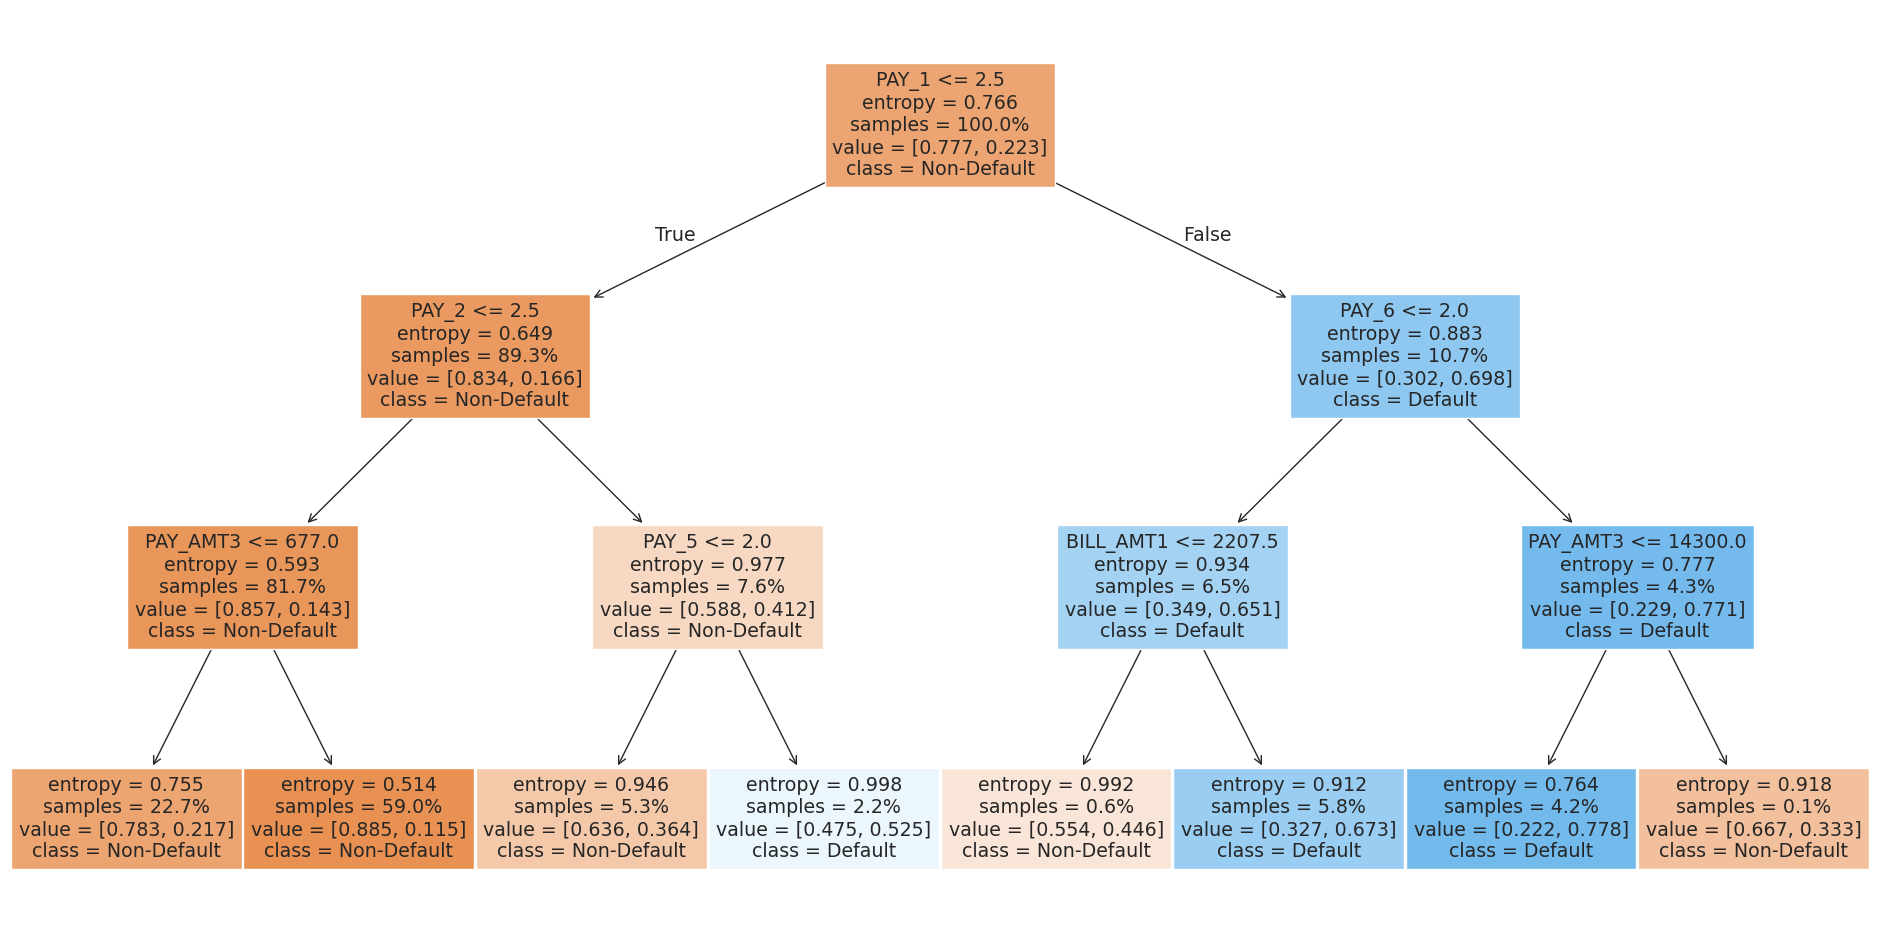


Training Decision Tree with Raw data
Class distribution with raw:
- Non-defaulters (0): 17246 (77.68%)
- Defaulters (1): 4954 (22.32%)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 5}
Best validation score: 0.4676
Test Scores:
- Accuracy:	0.8184
- Recall:	0.3452
- Precision:	0.6843
- F1-score:	0.4589
- AUC:		0.5274
Error with Raw data: local variable 'PrecisionRecallDisplay' referenced before assignment

Training Decision Tree with PCA
Variance explained by first 12 components: 0.8748
Class distribution with pca:
- Non-defaulters (0): 17246 (77.68%)
- Defaulters (1): 4954 (22.32%)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

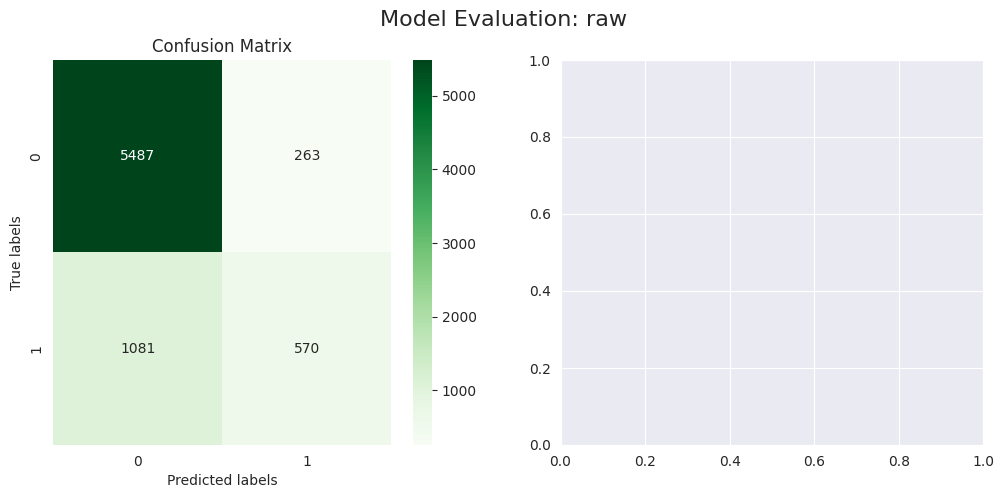

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=3, 
                             criterion='entropy', 
                             max_features=None)
clf.fit(X_train, y_train)
plt.figure(figsize=(24,12))
tree.plot_tree(decision_tree=clf,
               feature_names=X_train.columns, 
               class_names=['Non-Default','Default'],
               filled=True, proportion=True)
plt.show()


def plot_tree_test_scores(model, method, X_test_clean, X_test_pca, y_test, plot=False, model_type='decision_tree'):
    """
    Calculate and optionally plot test scores for tree-based models.
    
    Parameters:
    -----------
    model : trained model
        The trained tree-based model
    method : str
        The method used ('raw', 'pca', 'kmeans', 'kmeans_smote')
    X_test_clean : DataFrame
        The cleaned test data (for raw method)
    X_test_pca : DataFrame
        The PCA-transformed test data (for pca, kmeans, kmeans_smote methods)
    y_test : Series
        The test target values
    plot : bool, default=False
        Whether to plot the results
    model_type : str, default='decision_tree'
        Type of model ('decision_tree' or 'random_forest')
    
    Returns:
    --------
    tuple
        (accuracy, recall, precision, f1, auc)
    """
    # Determine which test data to use based on method
    if method == 'raw':
        X_test_s = X_test_clean.copy()
    else:
        # For PCA, kmeans, and kmeans_smote, use PCA-transformed data
        X_test_s = X_test_pca.copy()
    
    # Predict
    y_pred = model.predict(X_test_s)
    
    # Calculate metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, zero_division=0)
    test_recall = recall_score(y_test, y_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Calculate AUC if the model supports predict_proba
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_s)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        test_auc = auc(recall, precision)
    else:
        test_auc = np.nan
        y_pred_proba = None
    
    # Print metrics
    print("Test Scores:")
    print(f"- Accuracy:\t{test_acc:.4f}")
    print(f"- Recall:\t{test_recall:.4f}")
    print(f"- Precision:\t{test_precision:.4f}")
    print(f"- F1-score:\t{test_f1:.4f}")
    print(f"- AUC:\t\t{test_auc:.4f}")
    
    # Plot results if requested
    if plot:
        # Check model type
        if model_type == 'random_forest':
            # Use the 3-subplot layout with feature importance for Random Forest
            from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
            
            fig, axs = plt.subplots(1, 3, figsize=(15, 4))
            fig.suptitle(f"Random Forest with {method}", fontsize=16)
            
            # 1. Feature Importance
            if hasattr(model, 'feature_importances_'):
                tmp = pd.DataFrame({
                    'Feature': X_test_s.columns, 
                    'Feature importance': model.feature_importances_
                })
                tmp = tmp.sort_values(by='Feature importance', ascending=False)
                s = sns.barplot(x='Feature', y='Feature importance', data=tmp, ax=axs[0])
                s.set_xticklabels(s.get_xticklabels(), rotation=90)
                axs[0].set_title("Feature Importance")
            
            # 2. Confusion Matrix - updated to use ConfusionMatrixDisplay
            cm = confusion_matrix(y_test, y_pred, normalize='true')
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap=plt.cm.Greens, ax=axs[1])
            axs[1].set_title("Normalized Confusion Matrix")
            
            # 3. Precision-Recall Curve - updated to use PrecisionRecallDisplay
            no_skill = len(y_test[y_test == 1]) / len(y_test)
            disp = PrecisionRecallDisplay.from_estimator(
                model, X_test_s, y_test, ax=axs[2]
            )
            axs[2].axhline(no_skill, 0, 1, ls='--', label='No Skill')
            axs[2].set_ylim([-0.05, 1.05])
            axs[2].legend(loc='upper right')
            axs[2].set_title("Precision-Recall Curve")
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()
        else:
            # For decision trees, use the 2-subplot layout
            fig, axs = plt.subplots(1, 2, figsize=(12, 5))
            fig.suptitle(f"Model Evaluation: {method}", fontsize=16)
            
            # 1. Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, ax=axs[0])
            axs[0].set_xlabel('Predicted labels')
            axs[0].set_ylabel('True labels')
            axs[0].set_title('Confusion Matrix')
            
            # 2. Precision-Recall Curve
            if y_pred_proba is not None:
                no_skill = len(y_test[y_test == 1]) / len(y_test)
                PrecisionRecallDisplay.from_predictions(
                    y_test, y_pred_proba, ax=axs[1]
                )
                axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
                axs[1].set_title("Precision-Recall Curve")
                axs[1].legend()
            else:
                axs[1].text(0.5, 0.5, "Probability predictions not available", 
                           ha='center', va='center', fontsize=12)
                axs[1].set_title("Precision-Recall Curve (Not Available)")
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()
    
    return test_acc, test_recall, test_precision, test_f1, test_auc

def tree_pipeline(model, params, method='raw', random_state=42, model_type='decision_tree'):
    """
    Run the complete modeling pipeline for tree-based models with specified method.
    
    Parameters:
    -----------
    model : sklearn tree-based model
        The model to train (DecisionTreeClassifier or RandomForestClassifier)
    params : dict
        Parameter grid for GridSearchCV
    method : str, default='raw'
        Method to use: 'raw', 'pca', 'kmeans', 'kmeans_smote'
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    tuple
        (test_scores, y_pred_max, y_test)
    """
    max_f1 = 0
    y_pred_max = None
    y_test_max = None
    
    # Handle missing values
    X_train_clean = handle_missing_values(X_train)
    X_test_clean = handle_missing_values(X_test)
    
    # Initialize X_test_pca as None (will be set if using PCA)
    X_test_pca = None
    
    # Apply the specified method
    if method == 'raw':
        # Raw data - no PCA, no sampling
        X_train_s = X_train_clean.copy()
        y_train_s = y_train.copy()
        
    elif method == 'pca':
        # Normalize data before applying PCA
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_clean)
        X_test_scaled = scaler.transform(X_test_clean)
        
        # Apply PCA to normalized data
        pca = PCA(n_components=12, random_state=random_state)
        pca.fit(X_train_scaled)
        X_train_pca = pca.transform(X_train_scaled)
        
        # Print variance explained (for verification)
        explained_variance = pca.explained_variance_ratio_
        print(f"Variance explained by first {12} components: {sum(explained_variance):.4f}")
        
        # Transform test data with PCA
        X_test_pca_array = pca.transform(X_test_scaled)
        
        # Convert to DataFrame and ensure indices are reset
        X_train_s = pd.DataFrame(X_train_pca, 
                                columns=[f'PC{i}' for i in range(1, 12+1)])
        X_test_pca = pd.DataFrame(X_test_pca_array, 
                                columns=[f'PC{i}' for i in range(1, 12+1)])
        
        # Reset indices to ensure alignment
        X_train_s = X_train_s.reset_index(drop=True)
        y_train_s = y_train.copy().reset_index(drop=True)
        
    elif method == 'kmeans':
        # Apply PCA first
        pca = PCA(n_components=12, random_state=random_state)
        pca.fit(X_train_clean)
        X_train_pca = pca.transform(X_train_clean)
        
        # Transform test data with PCA
        X_test_pca_array = pca.transform(X_test_clean)
        X_test_pca = pd.DataFrame(X_test_pca_array, 
                                 columns=[f'PC{i}' for i in range(1, 12+1)])
        
        # Convert to DataFrame and ensure indices match
        X_train_pca_df = pd.DataFrame(X_train_pca, 
                                     columns=[f'PC{i}' for i in range(1, 12+1)])
        
        # Reset indices to ensure alignment
        X_train_pca_df = X_train_pca_df.reset_index(drop=True)
        y_train_reset = y_train.reset_index(drop=True)
        
        # Apply K-Means sampling
        # Separate the training data into default and non-default classes
        X_train_default = X_train_pca_df[y_train_reset == 1]
        X_train_non_default = X_train_pca_df[y_train_reset == 0]
        
        # Set the number of clusters to match the smaller class size
        n_clusters = len(X_train_default)
        
        # Apply KMeans clustering to the larger class (non-default)
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        X_train_non_default_copy = X_train_non_default.copy()
        X_train_non_default_copy['cluster'] = kmeans.fit_predict(X_train_non_default)
        
        # Select one representative sample from each cluster
        X_train_non_default_sampled = X_train_non_default_copy.groupby('cluster').apply(
            lambda x: x.sample(1, random_state=random_state)
        ).reset_index(drop=True).drop(columns=['cluster'])
        
        # Combine the sampled non-default data with the default data
        X_train_s = pd.concat([X_train_non_default_sampled, X_train_default])
        y_train_s = pd.Series(
            np.concatenate([
                np.zeros(len(X_train_non_default_sampled)), 
                np.ones(len(X_train_default))
            ])
        )
        
        # Shuffle the data
        X_train_s, y_train_s = shuffle(X_train_s, y_train_s, random_state=random_state)
        
    elif method == 'kmeans_smote':
        # Apply PCA first
        pca = PCA(n_components=12, random_state=random_state)
        pca.fit(X_train_clean)
        X_train_pca = pca.transform(X_train_clean)
        
        # Transform test data with PCA
        X_test_pca_array = pca.transform(X_test_clean)
        X_test_pca = pd.DataFrame(X_test_pca_array, 
                                 columns=[f'PC{i}' for i in range(1, 12+1)])
        
        # Convert to DataFrame and ensure indices match
        X_train_pca_df = pd.DataFrame(X_train_pca, 
                                     columns=[f'PC{i}' for i in range(1, 12+1)])
        
        # Reset indices to ensure alignment
        X_train_pca_df = X_train_pca_df.reset_index(drop=True)
        y_train_reset = y_train.reset_index(drop=True)
        
        # Apply KMeansSMOTE
        try:
            oversample = KMeansSMOTE(
                cluster_balance_threshold=0.00001, 
                random_state=random_state
            )
            X_train_s, y_train_s = oversample.fit_resample(X_train_pca_df, y_train_reset)
        except Exception as e:
            print(f"Error with KMeansSMOTE: {str(e)}")
            # Fallback to regular PCA if KMeansSMOTE fails
            X_train_s = X_train_pca_df
            y_train_s = y_train_reset
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Print class distribution
    unique, counts = np.unique(y_train_s, return_counts=True)
    class_dist = dict(zip(unique, counts))
    total = sum(counts)
    print(f"Class distribution with {method}:")
    print(f"- Non-defaulters (0): {class_dist.get(0, 0)} ({class_dist.get(0, 0)/total*100:.2f}%)")
    print(f"- Defaulters (1): {class_dist.get(1, 0)} ({class_dist.get(1, 0)/total*100:.2f}%)")
    
    # GridSearch for best parameters
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_s, y_train_s)
    
    # Print best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best validation score: {grid_search.best_score_:.4f}")
    
    # Get test scores - pass both test datasets
    test_scores = plot_tree_test_scores(grid_search.best_estimator_, method, X_test_clean, X_test_pca, y_test, plot=True, model_type=model_type)
    
    # Get best estimator
    best_estimator = grid_search.best_estimator_
    
    # Determine which test data to use based on method
    if method == 'raw':
        X_test_s = X_test_clean.copy()
    else:
        # For PCA, kmeans, and kmeans_smote, use PCA-transformed data
        X_test_s = X_test_pca.copy()
    
    # Predict on test set
    y_pred = best_estimator.predict(X_test_s)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    
    # Update best prediction if this one has better F1 score
    if f1 > max_f1:
        y_pred_max = y_pred
        y_test_max = y_test
        max_f1 = f1
    
    return test_scores, y_pred_max, y_test_max

methods = ['raw', 'pca', 'kmeans', 'kmeans_smote']
method_names = ['Raw data', 'PCA', 'PCA + K-Means sampling', 'PCA + KMeansSMOTE']

# Initialize results dictionary for Decision Trees
scores_dt = {
    'Accuracy': [0.0] * len(methods),
    'Recall': [0.0] * len(methods),
    'Precision': [0.0] * len(methods),
    'F1-score': [0.0] * len(methods),
    'AUC': [0.0] * len(methods),
}

# Define parameter grid for Decision Trees
params_dt = {
    'max_depth': [5, 10, 20, 30, 50],
    'criterion': ['entropy']
}

# Best prediction for summary plot
best_y_pred = None
best_f1 = -1

# Run tree_pipeline for each method with Decision Trees
for idx, method in enumerate(methods):
    print(f"\n{'='*50}")
    print(f"Training Decision Tree with {method_names[idx]}")
    print(f"{'='*50}")
    
    try:
        # Create a new Decision Tree instance for each run
        model = DecisionTreeClassifier(random_state=42)
        
        # Run the pipeline
        scores, y_pred, y_test = tree_pipeline(model, params_dt, method=method)
        
        # Store results
        scores_dt['Accuracy'][idx] = scores[0]
        scores_dt['Recall'][idx] = scores[1]
        scores_dt['Precision'][idx] = scores[2]
        scores_dt['F1-score'][idx] = scores[3]
        scores_dt['AUC'][idx] = scores[4]
        
        # Update best prediction if this one has better F1 score
        if scores[3] > best_f1:
            best_f1 = scores[3]
            best_y_pred = y_pred
    
    except Exception as e:
        print(f"Error with {method_names[idx]}: {str(e)}")
        # Continue with next method

# Create results DataFrame
scores_dt_df = pd.DataFrame(data=scores_dt, index=method_names)

# Plot summary
if best_y_pred is not None:
    plot = plot_summary(scores_dt_df["F1-score"], method_names, best_y_pred, y_test)

# Display results table
scores_dt_df
     


Random Forest


Training Random Forest with Raw data
Class distribution with raw:
- Non-defaulters (0): 17246 (77.68%)
- Defaulters (1): 4954 (22.32%)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'max_features': 'sqrt', 'n_estimators': 50}
Best validation score: 0.4751
Test Scores:
- Accuracy:	0.8185
- Recall:	0.3537
- Precision:	0.6791
- F1-score:	0.4652
- AUC:		0.5492


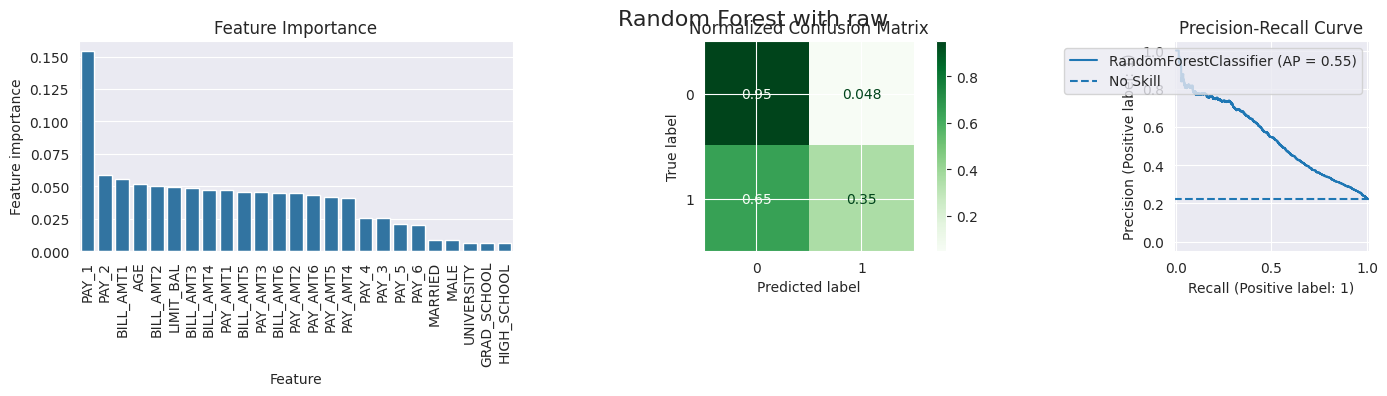


Training Random Forest with PCA
Variance explained by first 12 components: 0.8748
Class distribution with pca:
- Non-defaulters (0): 17246 (77.68%)
- Defaulters (1): 4954 (22.32%)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Best validation score: 0.4196
Test Scores:
- Accuracy:	0.8023
- Recall:	0.3016
- Precision:	0.6163
- F1-score:	0.4050
- AUC:		0.4897


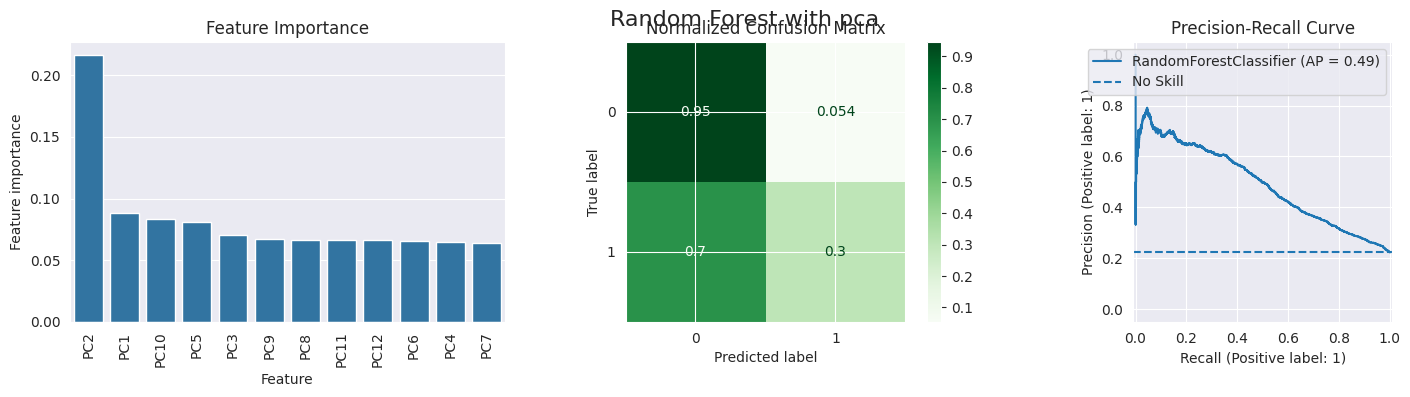


Training Random Forest with PCA + K-Means sampling
Class distribution with kmeans:
- Non-defaulters (0): 4954 (50.00%)
- Defaulters (1): 4954 (50.00%)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Best validation score: 0.8104
Test Scores:
- Accuracy:	0.5086
- Recall:	0.7850
- Precision:	0.2831
- F1-score:	0.4161
- AUC:		0.3464


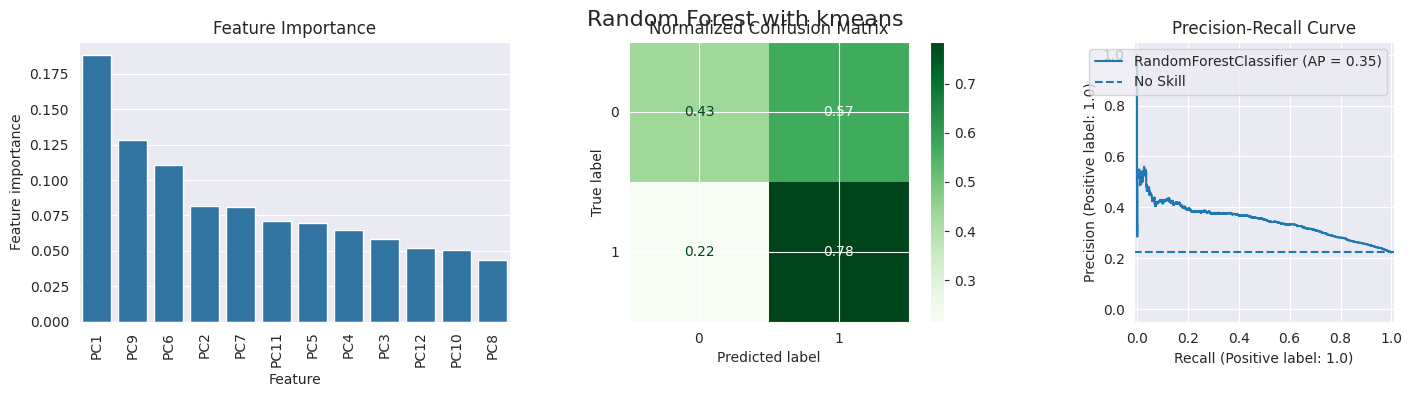


Training Random Forest with PCA + KMeansSMOTE
Class distribution with kmeans_smote:
- Non-defaulters (0): 17246 (49.99%)
- Defaulters (1): 17253 (50.01%)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Best validation score: 0.8042
Test Scores:
- Accuracy:	0.7308
- Recall:	0.3489
- Precision:	0.3858
- F1-score:	0.3664
- AUC:		0.3726


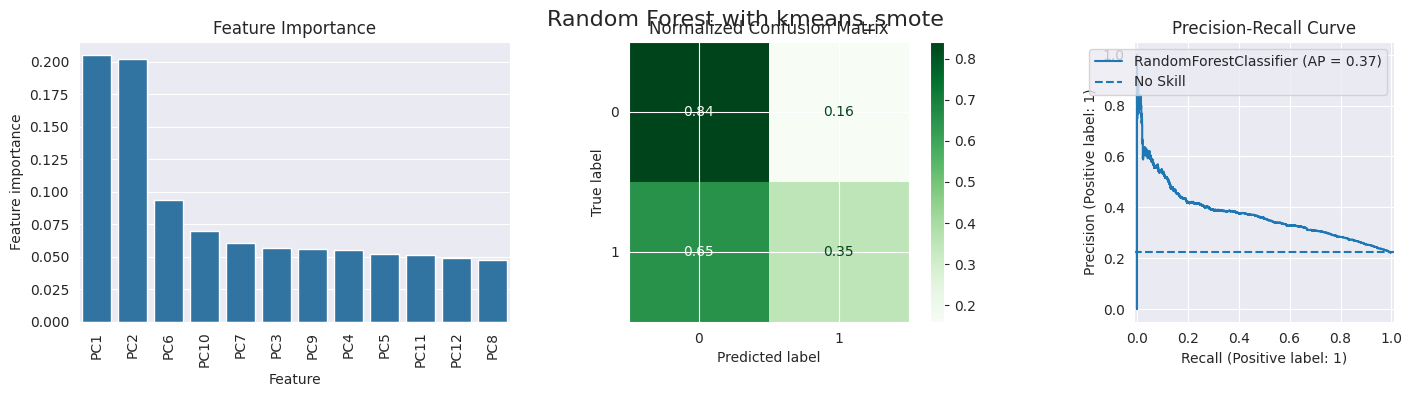

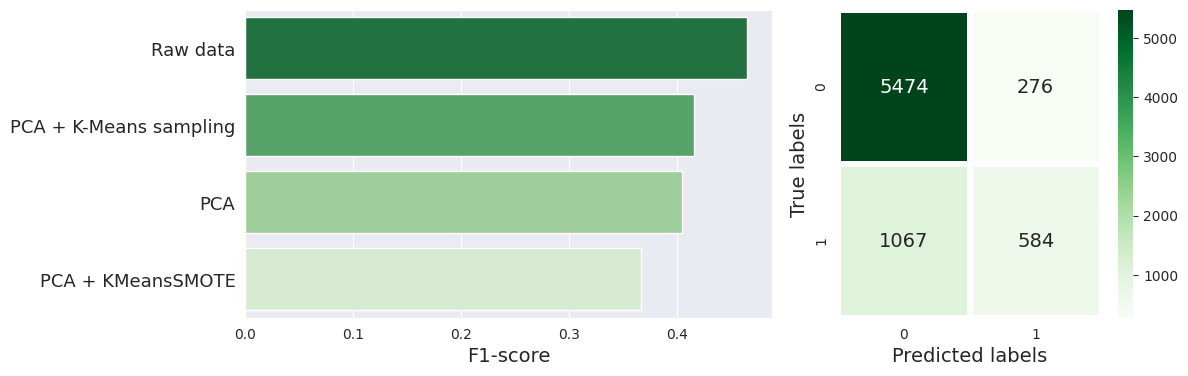

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.818538,0.353725,0.679070,0.465153,0.549164
PCA,0.802324,0.301635,0.616337,0.405043,0.489710
PCA + K-Means sampling,0.508580,0.784979,0.283093,0.416118,0.346376
PCA + KMeansSMOTE,0.730847,0.348879,0.385800,0.366412,0.372562


In [44]:
# Import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Define methods to evaluate
methods = ['raw', 'pca', 'kmeans', 'kmeans_smote']
method_names = ['Raw data', 'PCA', 'PCA + K-Means sampling', 'PCA + KMeansSMOTE']

# Initialize results dictionary for Random Forest
scores_rf = {
    'Accuracy': [0.0] * len(methods),
    'Recall': [0.0] * len(methods),
    'Precision': [0.0] * len(methods),
    'F1-score': [0.0] * len(methods),
    'AUC': [0.0] * len(methods),
}

# Define parameter grid for Random Forest with your specified parameters
params_rf = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt']
}

# Best prediction for summary plot
best_y_pred = None
best_f1 = -1

# Run tree_pipeline for each method with Random Forest
for idx, method in enumerate(methods):
    print(f"\n{'='*50}")
    print(f"Training Random Forest with {method_names[idx]}")
    print(f"{'='*50}")
    
    try:
        # Create a new Random Forest instance for each run
        model = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,           # Use all available cores
        verbose=0,           # Reduce output verbosity
        max_depth=20,        # Limit tree depth
        min_samples_split=5  # Require more samples to split a node
    )
        
        # Run the pipeline
        scores, y_pred, y_test = tree_pipeline(model, params_rf, method=method, model_type='random_forest')
        
        # Store results
        scores_rf['Accuracy'][idx] = scores[0]
        scores_rf['Recall'][idx] = scores[1]
        scores_rf['Precision'][idx] = scores[2]
        scores_rf['F1-score'][idx] = scores[3]
        scores_rf['AUC'][idx] = scores[4]
        
        # Update best prediction if this one has better F1 score
        if scores[3] > best_f1:
            best_f1 = scores[3]
            best_y_pred = y_pred
    
    except Exception as e:
        print(f"Error with {method_names[idx]}: {str(e)}")
        # Continue with next method

# Create results DataFrame
scores_rf_df = pd.DataFrame(data=scores_rf, index=method_names)

# Plot summary
if best_y_pred is not None:
    plot = plot_summary(scores_rf_df["F1-score"], method_names, best_y_pred, y_test)

# Display results table
scores_rf_df

Conclusion

In [45]:
def plot_model_comparison(scores_lr_df, scores_svm_df, scores_dt_df, scores_rf_df):
    """
    Create a comprehensive visualization comparing all models across different methods.
    
    Parameters:
    -----------
    scores_lr_df : DataFrame
        Results for Logistic Regression
    scores_svm_df : DataFrame
        Results for SVM
    scores_dt_df : DataFrame
        Results for Decision Tree
    scores_rf_df : DataFrame
        Results for Random Forest
    """
    # Combine all results
    models = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
    methods = scores_lr_df.index
    
    # Create a figure with subplots for each metric
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 15))
    fig.suptitle('Model Performance Comparison Across Methods', fontsize=16)
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        # Create DataFrame for this metric
        data = pd.DataFrame({
            'Logistic Regression': scores_lr_df[metric],
            'SVM': scores_svm_df[metric],
            'Decision Tree': scores_dt_df[metric],
            'Random Forest': scores_rf_df[metric]
        }, index=methods)
        
        # Plot as grouped bar chart
        data.plot(kind='bar', ax=axes[i], rot=0)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_xlabel('Preprocessing Method')
        axes[i].set_ylabel(metric)
        axes[i].legend(title='Model')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on bars
        for container in axes[i].containers:
            axes[i].bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # Create heatmap for F1-scores (often the most important metric for imbalanced data)
    plt.figure(figsize=(10, 8))
    f1_data = pd.DataFrame({
        'Logistic Regression': scores_lr_df['F1-score'],
        'SVM': scores_svm_df['F1-score'],
        'Decision Tree': scores_dt_df['F1-score'],
        'Random Forest': scores_rf_df['F1-score']
    }, index=methods)
    
    sns.heatmap(f1_data, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=.5)
    plt.title('F1-Score Comparison Across Models and Methods', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Find best overall model and method
    best_f1 = -1
    best_model = ""
    best_method = ""
    
    for model, df in zip(models, [scores_lr_df, scores_svm_df, scores_dt_df, scores_rf_df]):
        max_f1 = df['F1-score'].max()
        if max_f1 > best_f1:
            best_f1 = max_f1
            best_model = model
            best_method = df['F1-score'].idxmax()
    
    print(f"Best overall model: {best_model} with {best_method}")
    print(f"Best F1-score: {best_f1:.4f}")

# Call the function with your results dataframes
plot_model_comparison(scores_lr_df, scores_svm_df, scores_dt_df, scores_rf_df)

NameError: name 'scores_svm_df' is not defined